In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import dlc_practical_prologue2 as prologue

print('libraries imported')

libraries imported


To get the data for the first project, we are using one of the functions of *dlc_practical_prologe.py* that randomly generates one for us given a size parameter. It returns a tuple containing the: *training set, targets, classes* and *testing set, targets, classes*. 

In [2]:
sample_size = 1000
sets = prologue.generate_pair_sets(sample_size)

train_set = sets[0]
train_target = sets[1]
train_classes = sets[2]

test_set = sets[3]
test_target = sets[4]
test_classes = sets[5]

The inputs are grayscale MNIST images consisting of two channels ($2 \times 14 \times 14$) representing two different digits. As visualized below, target vector contains the index of the channels which have the highest digit between the two (channel $0$ or $1$). 

Therefore, our task is to maximize the prediction of this boolean value.

For the first training data point with two channels, target is 0


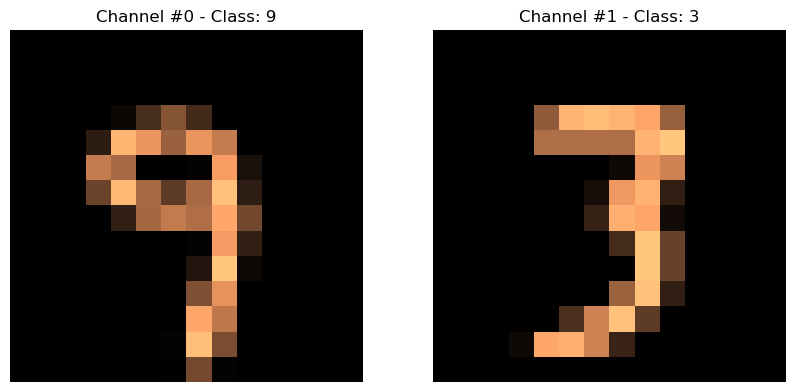

In [3]:
print('For the first training data point with two channels, target is {}'.format(train_target[0]))
fig1, axes = plt.subplots(1, 2, figsize = (10, 7))
ax = axes.ravel()

for i in range(len(ax)):
    ax[i].set_title('Channel #{} - Class: {}'.format(i, train_classes[0][i]))
    ax[i].imshow(train_set[0][i], cmap='copper')
    ax[i].axis('off')
plt.show()

Function to train the model by moving it through the given mini batch size and using Adam as an optimizer.

In [4]:
def train_model(n_epochs, eta, loss_criterion, model, train_input, train_target, train_classes, mini_batch_size):
    aux_loss_criterion = nn.CrossEntropyLoss()
    gamma = 1.0
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01, lr = eta)
    for _ in range(n_epochs):
        acc_loss = 0 ## set error as 0 each iteration
        ## Using mini-batches
        for b in range(0, train_input.size(0), mini_batch_size): 
            output = model(train_input.narrow(0, b, mini_batch_size))
            # output, output_aux = model(train_input.narrow(0, b, mini_batch_size))
            # print('output shape', output.shape, output_aux.shape)
            # print(output)
            # print(output_aux)
            # print('Loss Shapes: Output: {}, Target: {}'.format(output.shape, train_target.narrow(0, b, mini_batch_size).shape))
            loss1 = loss_criterion(output, train_target.narrow(0, b, mini_batch_size).float())
            # print(output_aux.shape, train_classes.narrow(0, b, mini_batch_size).shape)
            # print(train_classes.narrow(0, b, mini_batch_size))
            # aux_loss = aux_loss_criterion(output_aux, train_classes.narrow(0, b, mini_batch_size))
            # loss = loss1 + (gamma * aux_loss)
            
            loss = loss1
            acc_loss = acc_loss + loss.item()

            model.zero_grad() ## setting the gradients to zero before the loss calculation
            loss.backward()
            optimizer.step()                    
    # print('Final Output: ', output, output.shape)
    # print(torch.argmax(output, dim=1))
    # print('Model Training Finished - Final loss after {} epochs: {}'.format(n_epochs, acc_loss))

Round the final values outputted from the network into binary values and compare them with the target binary matrix in order to get the number of errors.

The sigmoid function $\sigma(x) = \frac 1 {1+exp(-x)}$ is applied to the output to distribute the output values between $0$ and $1$, after which a rounding process happens to finally compare them with our binary targets. 

In [5]:
def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0
    with torch.no_grad():
        for b in range(0, input.size(0), mini_batch_size):
            output = torch.sigmoid(model(input.narrow(0, b, mini_batch_size)))
            errors = torch.where(torch.round(output) != target.narrow(0, b, mini_batch_size))

            ## Errors return a tuple with the first element being a tensor with indexes
            ## Where the targets and predictions dont match
            ## Therefore we get the size of this tensor as a number of errors
            nb_errors += errors[0].size(0) 
    return nb_errors

##### Defining both models

The first model will be a classical Binary Convolutional Network Classifier inspired by LeNet, that takes the number of the hidden layers of the final fully connected layer as a parameter. 
As seen from the results below, it suffers from overfitting at the moment therefore it should be modified (dropout to be added next).

The second model will be a Multi-Layer Perceptron with only linear hidden layers, constructed in order to compare the difference between this and the convolutional network, measuring the overfitting too. 

They both includes multiple dropout layers with respective rates of $0.4$ and share a weight decay parameter on the Adam Optimizer, as measures to combat overfitting.

In [6]:
# see file for code
from MLP_model import MLP

Binary Convolutional Neural Network

In [7]:
# see file for code
from CNN_model import BinaryCNN

Training cell for one model, to be easily switched between MLP and CNN.

Hyperparameters after benchmarking (average over 10 runs): $40$ - $50$ batch size seems to be the best, $0.001$ or $0.0001$ weight decay, $10-25$ epochs sufficient 

In [8]:
### Testing for auxilary loss

# target = train_classes.narrow(0, 1, 5)
# loss = nn.CrossEntropyLoss()
# input = torch.randn(3, 5, requires_grad=True)
# # target = torch.empty(3, dtype=torch.long).random_(5)
# # output = loss(input, target)
# # output

# input = torch.randn(3, 5, requires_grad=True)

In [ ]:
binary_criterion = nn.BCEWithLogitsLoss()
eta = 0.001
mini_batch_size = 50
nb_epochs = 25
n_runs = 5
hidden_layers = [4096, 2048, 1024, 512, 256, 128, 64, 32]
epochs = [1, 5, 10, 15, 25, 40, 50, 80, 100, 200, 1000]
batches = [40, 50, 100, 500]
dropouts = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

# for d in dropouts:
avg_error_train = []
avg_error_test = []
for i in range(n_runs):
    model = BinaryCNN(dropout_rate = 0.2)
    train_model(nb_epochs, eta, binary_criterion, model, train_set, train_target, train_classes.to(torch.long), mini_batch_size)
    
    model.eval()    
    error_train = compute_nb_errors(model, train_set, train_target.to(torch.float32), mini_batch_size)
    avg_error_train.append(error_train / train_set.size(0))
    error_test = compute_nb_errors(model, test_set, test_target.to(torch.float32), mini_batch_size)
    avg_error_test.append(error_test / train_set.size(0))

print('Classification Error on the training set with {} fc dropout - Average: {}%'.format('0.2', (sum(avg_error_train) / n_runs) * 100))
print('Classification Error on the testing set with {} fc dropout - Average: {}%, Minimum: {}%'.format('0.2', (sum(avg_error_test) / n_runs) * 100, min(avg_error_test) * 100))           
print('')

Training cell for both models to calculate their performance on the testing set and to be used for benchmarking & fine-tuning with different hyperparameters.

In [ ]:
## Shared parameters to both models
hidden_layers = [50, 200, 500, 1000]
binary_criterion = nn.BCEWithLogitsLoss()
mini_batch_size = 50
nb_epochs = 25
n_runs = 10
eta = 0.001

# Lists for Plotting & Benchmarks Purposes
all_epochs = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
all_errors_cnn_train = []
all_errors_mlp_train = []
all_errors_cnn = []
all_errors_mlp = []


for e in range(len(all_epochs)):
    avg_error_train_cnn = []
    avg_error_test_cnn = []
    avg_error_train_mlp = []
    avg_error_test_mlp = []
    print('Average over {} Epochs'.format(all_epochs[e]))
    for i in range(n_runs):   
        conv_model = BinaryCNN(dropout_rate = 0.2)
        mlp_model = MLP(dropout_rate = 0.4)
        
        ## Training CNN
        train_model(all_epochs[e], eta, binary_criterion, conv_model, train_set, train_target.to(torch.float32), train_classes, mini_batch_size)
        ## Training MLP
        train_model(all_epochs[e], eta, binary_criterion, mlp_model, train_set, train_target.to(torch.float32), train_classes, mini_batch_size)
            
        conv_model.eval()
        conv_errors_train = compute_nb_errors(conv_model, train_set, train_target.to(torch.float32), mini_batch_size)
        conv_errors_test = compute_nb_errors(conv_model, test_set, test_target.to(torch.float32), mini_batch_size)
        avg_error_train_cnn.append(conv_errors_train / train_set.size(0))
        avg_error_test_cnn.append(conv_errors_test / test_set.size(0))
        
        mlp_model.eval()
        mlp_errors_train = compute_nb_errors(mlp_model, train_set, train_target.to(torch.float32), mini_batch_size)
        mlp_errors_test = compute_nb_errors(mlp_model, test_set, test_target.to(torch.float32), mini_batch_size)
        avg_error_train_mlp.append(mlp_errors_train / train_set.size(0))
        avg_error_test_mlp.append(mlp_errors_test / test_set.size(0))

    all_errors_cnn_train.append(sum(avg_error_train_cnn) / n_runs)
    all_errors_cnn.append(sum(avg_error_test_cnn) / n_runs)
    
    all_errors_mlp_train.append(sum(avg_error_train_mlp) / n_runs)
    all_errors_mlp.append(sum(avg_error_test_mlp) / n_runs)
            
    print('CNN - Classification Error on the training set: Average: {:.2f}%, Minimum: {:.2f}%'.format((all_errors_cnn_train[e] * 100), (min(avg_error_train_cnn) * 100)))
    print('CNN - Classification Error on the testing set: Average: {:.2f}%, Minimum: {:.2f}%'.format((all_errors_cnn[e] * 100), (min(avg_error_test_cnn) * 100)))
    print('MLP - Classification Error on the training set: Average: {:.2f}%, Minimum: {:.2f}%'.format((all_errors_mlp_train[e] * 100), (min(avg_error_train_mlp) * 100)))
    print('MLP - Classification Error on the testing set: Average: {:.2f}%, Minimum: {:.2f}%\n'.format((all_errors_mlp[e] * 100), (min(avg_error_test_mlp) * 100)))

As we can view from the plot below, the overfitting on the testing set persists no matter the number of epochs.

In [ ]:
import seaborn as sns
sns.set()

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Error rate on both models - Average over 10runs - Dropout')
axs[0].set_title("Train Set")
# plt.xlabel('Number of Epochs')
# plt.ylabel('Error Rate')
axs[0].plot(all_epochs, all_errors_cnn_train, alpha=0.6, linewidth=4, color='turquoise', label='CNN')
axs[0].plot(all_epochs, all_errors_mlp_train, alpha=0.6, linewidth=4, color='maroon', label='MLP')
axs[0].legend(loc='upper right')

axs[1].set
axs[1].set_title("Test Set")
axs[1].plot(all_epochs, all_errors_cnn, alpha=0.6, linewidth=4, color='turquoise', label='CNN')
axs[1].plot(all_epochs, all_errors_mlp, alpha=0.6, linewidth=4, color='maroon', label='MLP')
axs[1].legend(loc='upper right')

for ax in axs.flat:
    ax.set(xlabel='Number of Epochs', ylabel='Error Rate', ylim=(-0.01, 0.5))
plt.show()